# Variables processing

- https://www.youtube.com/playlist?list=PLTp22zwXLwreSR9MBy76igBAAjrQ6F_rb
- [Based on this Notebook (actually heavily copy-pasted, but I learned a lot)](https://www.kaggle.com/vikingpathak/rmse-0-09-extensive-data-exploration-a-z/notebook#Feature-Engineering)

In [1169]:
import itertools

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import StandardScaler


import warnings
warnings.simplefilter('ignore')

sns.set_theme(style="darkgrid")

## Importing the data

In [1170]:
train_data = pd.read_csv("../data/pre-processed/train.csv", delimiter=",",header=0, index_col=0)
sale_price = train_data["SalePrice"]
# train_data = train_data.drop("SalePrice",axis=1)
print(train_data.shape)
train_data.head()

(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1171]:
test_data = pd.read_csv("../data/pre-processed/test.csv", delimiter=",",header=0, index_col=0)
print(test_data.shape)
test_data.head()

(1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Datasets will be concatenated in order to have more efficient preocessing.

## Data concatenation

In [1172]:
ntrain = train_data.shape[0]
ntest = test_data.shape[0]

concat_data = pd.concat((train_data, test_data)).reset_index(drop=True)

nindex, nfeatures = concat_data.shape

## Missing values study

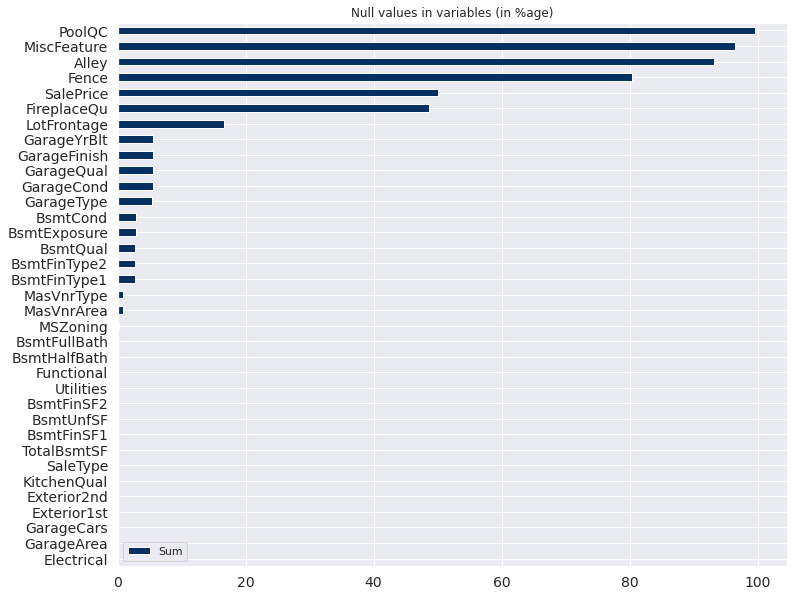

In [1173]:
## Get the dataframe with all the features and SUM of the NaN values present
df_null_count = concat_data.isnull().sum(axis=0).to_frame().rename({0:"Sum"}, axis=1)

## Select only those features who have atleast 1 NaN value
df_null_count = df_null_count[df_null_count['Sum'] > 0 ]

## Change the SUM to PERCENTAGE 
df_null_count['Sum'] = df_null_count['Sum']*(100/nindex)

## Plot a Horizontal Bar Graph
df_null_count.sort_values(by="Sum", ascending=True).plot(kind='barh', figsize=(12,10),
                                                         fontsize=14, colormap="RdBu_r",
                                                         title="Null values in variables (in %age)")
plt.show()

## Categorical Variables

Here we will group the categorical variables to process them by either converting to ordinal variables or fix None value when relevant 

In [1174]:
## PoolQC
concat_data["PoolQC"] = concat_data["PoolQC"].fillna("None")
quality_map = {"None": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4}
concat_data["PoolQC"].replace(quality_map,inplace=True)

In [1175]:
## MiscFeature
concat_data["MiscFeature"] = concat_data["MiscFeature"].fillna("None")
concat_data["MiscFeature"].unique()

array(['None', 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [1176]:
## Alley
concat_data["Alley"] = concat_data["Alley"].fillna("None")
concat_data["Alley"].unique()

array(['None', 'Grvl', 'Pave'], dtype=object)

In [1177]:
## Fence
concat_data["Fence"] = concat_data["Fence"].fillna("None")
concat_data["Fence"].unique()

array(['None', 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

In [1178]:
## Fireplace quality 
concat_data["FireplaceQu"] = concat_data["FireplaceQu"].fillna("None")
quality_map = {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
concat_data["FireplaceQu"].replace(quality_map,inplace=True)

### Garage related features

In [1179]:
## finiding all empty/nan/null values for the garage related variables

df_garage = concat_data[[
    'GarageYrBlt', 'GarageCond', 'GarageFinish',
    'GarageQual', 'GarageType', 'GarageCars', 'GarageArea'
]][ 
    concat_data['GarageType'].isnull() 
]

df_garage.head()

,GarageYrBlt,GarageCond,GarageFinish,GarageQual,GarageType,GarageCars,GarageArea
39,NaN,NaN,NaN,NaN,NaN,0.0,0.0
48,NaN,NaN,NaN,NaN,NaN,0.0,0.0
78,NaN,NaN,NaN,NaN,NaN,0.0,0.0
88,NaN,NaN,NaN,NaN,NaN,0.0,0.0
89,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [1180]:
# replace NaN by None for categorical values
for feature in ['GarageCond', 'GarageFinish', 'GarageQual', 'GarageType']:
    concat_data[feature].fillna(value='None', inplace=True)

# replace NaN by 0 for Numerical values
for feature in ['GarageYrBlt', 'GarageCars', 'GarageArea']:
    concat_data[feature].fillna(value=0, inplace=True)

In [1181]:
# Convert catagorical vairables to ordinal variables

quality_map = {"None": 0, "Po": 1,"Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

concat_data['GarageQual'].replace(quality_map, inplace=True)
concat_data['GarageCond'].replace(quality_map, inplace=True)

quality_map = {
    "None": 0, "Unf": 1, "RFn": 2, "Fin": 3
}

concat_data['GarageFinish'].replace(quality_map, inplace=True)

### Basement related Features

In [1182]:
no_basement_df = concat_data[[
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtFinSF1', 
    'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'TotalBsmtSF'
]][
    concat_data['BsmtQual'].isnull()
]

no_basement_df.head()

,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,TotalBsmtSF
17,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
39,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
90,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
102,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
156,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [1183]:
# replace NaN by None for categorical values
for feature in ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']:
    concat_data[feature].fillna(value='None', inplace=True)

# replace NaN by 0 for Numerical values
for feature in ['BsmtFinSF1', 'BsmtFinSF2','BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'TotalBsmtSF']:
    concat_data[feature].fillna(value=0, inplace=True)

In [1184]:
# Convert catagorical variables to ordinal variables

''' BsmtCond and BsmtQual '''

quality_map = {
    "None": 0, "Po": 1,"Fa": 2, "TA": 3, "Gd": 4, "Ex": 5
}

concat_data['BsmtCond'].replace(quality_map, inplace=True)
concat_data['BsmtQual'].replace(quality_map, inplace=True)

''' BsmtExposure '''

quality_map = {
    "None": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4
}

concat_data['BsmtExposure'].replace(quality_map, inplace=True)

''' BsmtFinType1 and BsmtFinType2 '''

quality_map = {
    "None": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6
}

concat_data['BsmtFinType1'].replace(quality_map, inplace=True)
concat_data['BsmtFinType2'].replace(quality_map, inplace=True)

In [1185]:
# MSZoning  
mode_val = concat_data.MSZoning.value_counts().idxmax()    # 'RL'
concat_data['MSZoning'].fillna(mode_val, inplace=True)
concat_data['MSZoning'].replace({'C (all)': 'C'}, inplace=True)

# utilities
concat_data.drop("Utilities", inplace=True, axis=1)

# Functional 
mode_val = concat_data.Functional.value_counts().idxmax()    #'Typ'
concat_data['Functional'].fillna(mode_val, inplace=True)

# Exterior1st Exterior2nd
concat_data.Exterior1st.fillna(value='Other', inplace=True)
concat_data.Exterior2nd.fillna(value='Other', inplace=True)

# SaleType
concat_data.SaleType.fillna(value='Other', inplace=True)

# Electrical
mode_val = concat_data.Electrical.value_counts().idxmax()    # 'SBrkr'
concat_data['Electrical'].fillna(mode_val, inplace=True) 

# KitchenQual
mode_val = concat_data.KitchenQual.value_counts().idxmax()    # 'TA'
concat_data['KitchenQual'].fillna(value=mode_val, inplace=True)

quality_map = {
    "Po": 0,"Fa": 1, "TA": 2, "Gd": 3, "Ex": 4
}
concat_data['KitchenQual'].replace(quality_map, inplace=True)

In [1186]:
''' Street '''
concat_data['Street'].replace({'Grvl': 0, 'Pave': 1}, inplace=True)

''' CentralAir '''
concat_data['CentralAir'].replace({'Y': 1, 'N': 0}, inplace=True)

''' HeatingQC | ExterQual | ExterCond'''
quality_map = {
    "Po": 0,"Fa": 1, "TA": 2, "Gd": 3, "Ex": 4
}
concat_data.HeatingQC.replace(quality_map, inplace=True)
concat_data.ExterQual.replace(quality_map, inplace=True)
concat_data.ExterCond.replace(quality_map, inplace=True)

''' LandSlope '''
quality_map = { 'Sev': 0, 'Mod': 1, 'Gtl': 2 }
concat_data.LandSlope.replace(quality_map, inplace=True)

''' LotShape '''
quality_map = { 'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3 }
concat_data.LotShape.replace(quality_map, inplace=True)

''' MSSubClass '''
class_map = {
    20:'Class1', 30:'Class2', 40:'Class3', 45:'Class4', 50:'Class5', 60:'Class6', 
    70:'Class7', 75:'Class8', 80:'Class9', 85:'Class10', 90:'Class11', 120:'Class12',
    150:'Class13', 160:'Class14', 180:'Class15', 190:'Class16'
}
concat_data.MSSubClass.replace(class_map, inplace=True)

## Quantitative Variables

Here we will group the quantitative variables to process them

Skewness Co-efficient: -0.857
Kurotisis Co-efficient: 2.069


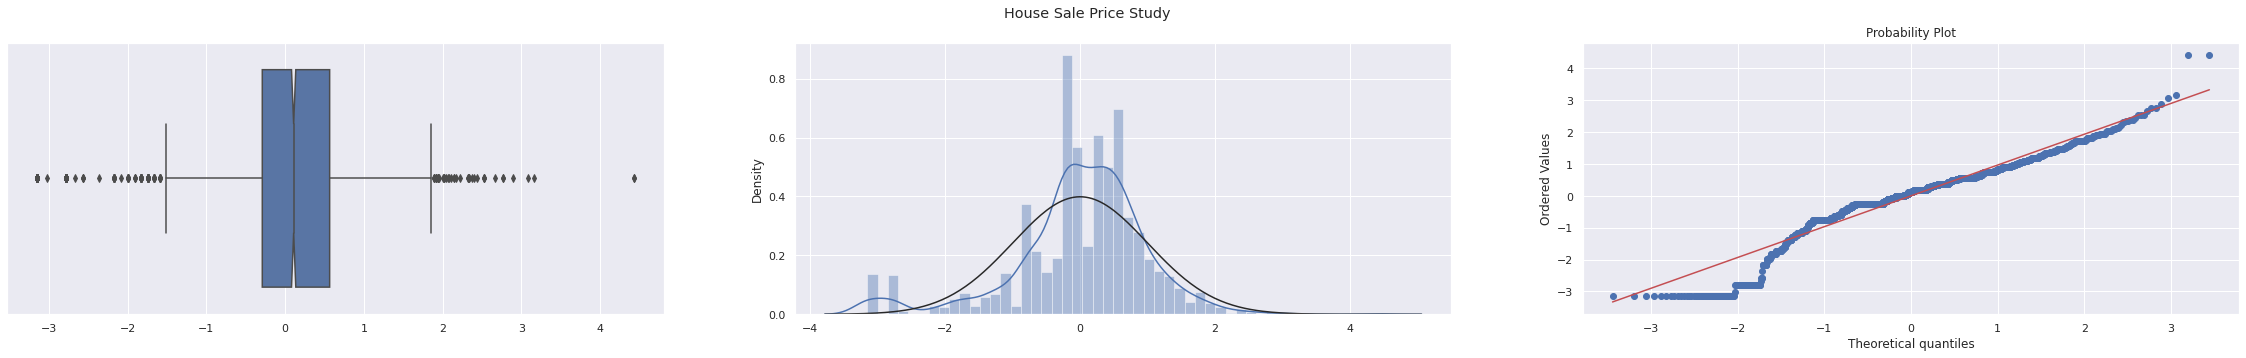

In [1187]:
## Lotfrontage

# NO MISSING VALUES IMPUTATION IMPUTATION
# log-trandform
log_lot_frontage = np.log1p(concat_data["LotFrontage"].dropna())
scaler = StandardScaler().fit(log_lot_frontage.values.reshape(-1,1))
transformed_lot_frontage = scaler.transform(log_lot_frontage.values.reshape(-1,1))

print(f"Skewness Co-efficient: {round(log_lot_frontage.dropna().skew(), 3)}")
print(f"Kurotisis Co-efficient: {round(log_lot_frontage.dropna().kurtosis(), 3)}")

## Target description plots
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(40,5))
fig.suptitle("House Sale Price Study")

# Histogram 
sns.distplot(transformed_lot_frontage, fit=stats.norm, ax=ax2)

# Q-Q Probability plot
### flatten center-scale tuple
import itertools
flattened_tranformed = list(itertools.chain(*transformed_lot_frontage))
stats.probplot(np.asanyarray(flattened_tranformed), plot=ax3)

#boxplot
sns.boxplot(transformed_lot_frontage, notch=True, ax=ax1)

plt.show()

count    2919.000000
mean       69.088386
std        21.317898
min        21.000000
25%        60.000000
50%        68.000000
75%        78.000000
max       313.000000
Name: LotFrontage, dtype: float64
Skewness Co-efficient: -0.995
Kurotisis Co-efficient: 3.133


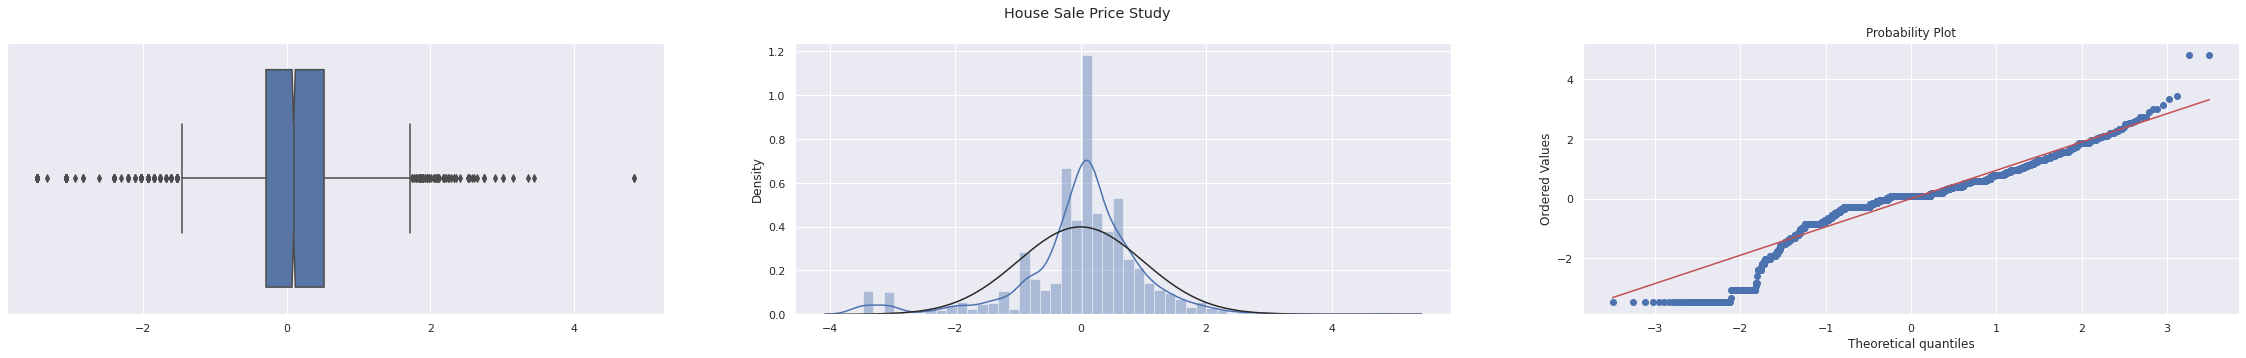

In [1188]:
# MISSING VALUES IMPUTATION IMPUTATION

# Median imputation to avoid adding skewness to data
concat_data["LotFrontage"].fillna(value=concat_data["LotFrontage"].median(), inplace=True)
print(concat_data["LotFrontage"].describe())


# log-trandform
log_lot_frontage = np.log1p(concat_data["LotFrontage"])
scaler = StandardScaler().fit(log_lot_frontage.values.reshape(-1,1))
transformed_lot_frontage = scaler.transform(log_lot_frontage.values.reshape(-1,1))

print(f"Skewness Co-efficient: {round(log_lot_frontage.skew(), 3)}")
print(f"Kurotisis Co-efficient: {round(log_lot_frontage.kurtosis(), 3)}")

## Target description plots
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(40,5))
fig.suptitle("House Sale Price Study")

# Histogram 
sns.distplot(transformed_lot_frontage, fit=stats.norm, ax=ax2)

# Q-Q Probability plot
### flatten center-scale tuple
import itertools
flattened_tranformed = list(itertools.chain(*transformed_lot_frontage))
stats.probplot(np.asanyarray(flattened_tranformed), plot=ax3)

#boxplot
sns.boxplot(transformed_lot_frontage, notch=True, ax=ax1)

plt.show()

In [1189]:
## Masonry Veneer Type and Area

# print(concat_data["MasVnrArea"].unique())
print(concat_data["MasVnrType"].unique())

mode_val = concat_data.MasVnrType.value_counts().idxmax()    # 'None'
concat_data['MasVnrType'].fillna(mode_val, inplace=True) 

median_val = concat_data.MasVnrArea.median()     # 0
concat_data['MasVnrArea'].fillna(median_val, inplace=True)

['BrkFace' 'None' 'Stone' 'BrkCmn' nan]


In [1190]:
concat_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,Class6,RL,65.0,8450,1,None,3,Lvl,Inside,2,...,0,0,None,None,0,2,2008,WD,Normal,208500.0
1,Class1,RL,80.0,9600,1,None,3,Lvl,FR2,2,...,0,0,None,None,0,5,2007,WD,Normal,181500.0
2,Class6,RL,68.0,11250,1,None,2,Lvl,Inside,2,...,0,0,None,None,0,9,2008,WD,Normal,223500.0
3,Class7,RL,60.0,9550,1,None,2,Lvl,Corner,2,...,0,0,None,None,0,2,2006,WD,Abnorml,140000.0
4,Class6,RL,84.0,14260,1,None,2,Lvl,FR2,2,...,0,0,None,None,0,12,2008,WD,Normal,250000.0


# Feature Engineering

In [1191]:
'''
    Usually we rely more on the total area of the house rather than talking about individual areas.
    Create a new feature which sums up all the area parameters to give us the total area available in the house.
'''
concat_data['TotalSF'] = concat_data['1stFlrSF'] + concat_data['2ndFlrSF'] + concat_data['GrLivArea'] + concat_data['TotalBsmtSF']

In [1192]:
'''
    The Year features do not provide much information. 
    We can rather work on getting more concrete information like
    No. of Years ie Age instead of actual year.
'''
## Age of the house at the time of buying
concat_data['Age'] = concat_data.YrSold - concat_data.YearBuilt

## No. of years since the house was remodeled at the time of buying
concat_data['AgeRemod'] = concat_data.YrSold - concat_data.YearRemodAdd

In [1193]:
'''
    For the houses without garages we have already impted them with 0.0
    So, before building the new feature  we will replace them with the corresponding values in YrSold.
    This will ensure that the AgeGarage feature will be 0 for the houses that do not have Garage.
    If we do not perform the above operation then we will get an Age which is ~ 2000.
'''
concat_data['GarageYrBlt'].replace({0.0: np.nan}, inplace=True)
concat_data['GarageYrBlt'].fillna(concat_data['YrSold'], inplace=True)
concat_data['AgeGarage'] = concat_data.YrSold - concat_data.GarageYrBlt

In [1194]:
(concat_data.YrSold - concat_data.YearBuilt).unique()

array([  5,  31,   7,  91,   8,  16,   3,  36,  77,  69,  43,   1,  46,
        48,  78,  40,  39,   4,  51,   6,  42,   2,  59,  49,  81,  88,
        15,  55,  57,  53,  41,  24,  33,  47,  89,  10,  72,  25,  52,
        44,   0,  87,  12,  65,  34,  11,  56,  95,  60,  99,  14,  94,
        13,  45,  97,  90,  30,  76, 122,  54,  62,  20,  37,  68,  50,
        71,   9,  38,  18,  58,  70,  32,  35,  83,  84,  66,  19,  22,
        86,  98, 114,  93,  75,  82,  17, 106,  29,  96,  27,  92, 128,
        61,  67,  21,  26, 108,  28,  63,  73,  74,  80, 115, 126, 102,
        85,  23, 110, 117, 129,  64, 100, 111, 104, 119, 127, 107, 135,
       109, 136, 103,  79, 125, 120, 118, 113, 112,  -1, 101])

In [1195]:
concat_data.Age       =  concat_data.Age.map(lambda x: 0 if x < 0 else x)
concat_data.AgeRemod  =  concat_data.AgeRemod.map(lambda x: 0 if x < 0 else x)
concat_data.AgeGarage =  concat_data.AgeGarage.map(lambda x: 0 if x < 0 else x)

concat_data.drop(
    ['YrSold', 'YearBuilt','YearRemodAdd','GarageYrBlt', 'MoSold'], 
    axis=1, inplace=True
)

## Numeric Features assessment for outlier detection

In [1196]:
def log_center_scale(feature_data):    
    # log transform
    log = np.log1p(feature_data)    
    # center-scaling
    scaler = StandardScaler().fit(log.values.reshape(-1,1))
    logged_centered_scaled = scaler.transform(log.values.reshape(-1,1))    
    
    return logged_centered_scaled, scaler

In [1197]:
def plot_numeric_features(feature):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=110)

    sns.distplot(concat_data[feature], ax=ax1)
    sns.scatterplot(concat_data[feature], sale_price, ax=ax2)
    sns.boxplot(concat_data[feature], ax=ax3, orient='v', width=0.2)

    print("Skewness Coefficient of LotFrontage is %.2f" %concat_data[feature].skew())
    print(f"Kurotisis Co-efficient: {round(log_lot_frontage.dropna().kurtosis(), 3)}")

    ax1.set_yticks([])
    
    return plt

In [1198]:
import itertools

target_data, target_scaler = log_center_scale(concat_data["SalePrice"])
target_data = list(itertools.chain(*target_data))
    
def plot_transformed_numeric_features(feature, target_data=target_data):
    feature_data, feature_scaler = log_center_scale(concat_data[feature])
    
    # flatten
    feature_data = list(itertools.chain(*feature_data))    
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=110)    
    sns.distplot(feature_data, ax=ax1)
    df_local = pd.DataFrame({feature:feature_data, "SalePrice":target_data})
    
    sns.scatterplot(data=df_local, x=feature, y="SalePrice" ,ax=ax2)
    sns.boxplot(feature_data, ax=ax3, orient='v', width=0.2)

    print("Skewness Coefficient of LotFrontage is %.2f" %stats.skew(feature_data))
    print(f"Kurotisis Co-efficient: {round(stats.kurtosis(feature_data), 3)}")
    
    ax1.set_yticks([])
    
    return plt

### Outlier Detection

### LotFrontage

Skewness Coefficient of LotFrontage is 1.68
Kurotisis Co-efficient: 3.133


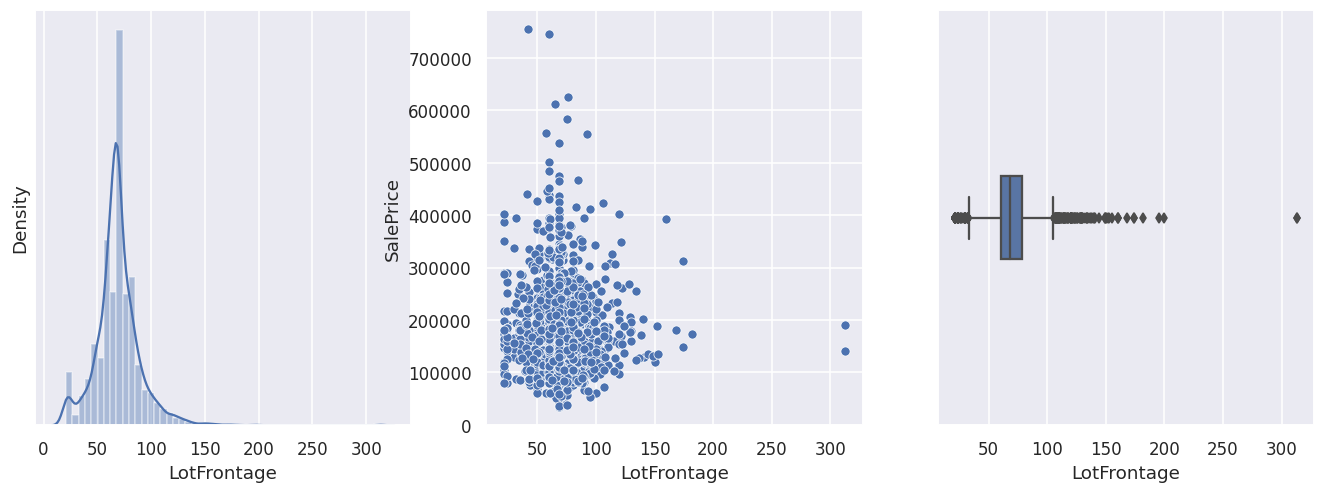

In [1199]:
plot_numeric_features("LotFrontage").show()

### LotArea

Skewness Coefficient of LotFrontage is 12.83
Kurotisis Co-efficient: 3.133


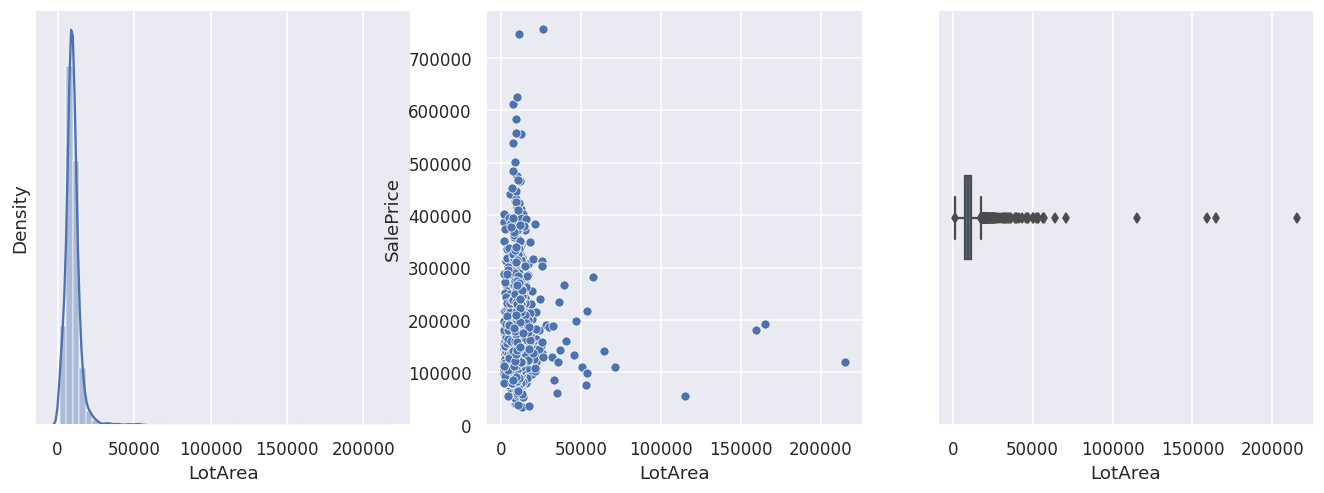

In [1200]:
plot_numeric_features("LotArea").show()

### BsmtFinSF1

Skewness Coefficient of LotFrontage is 1.43
Kurotisis Co-efficient: 3.133


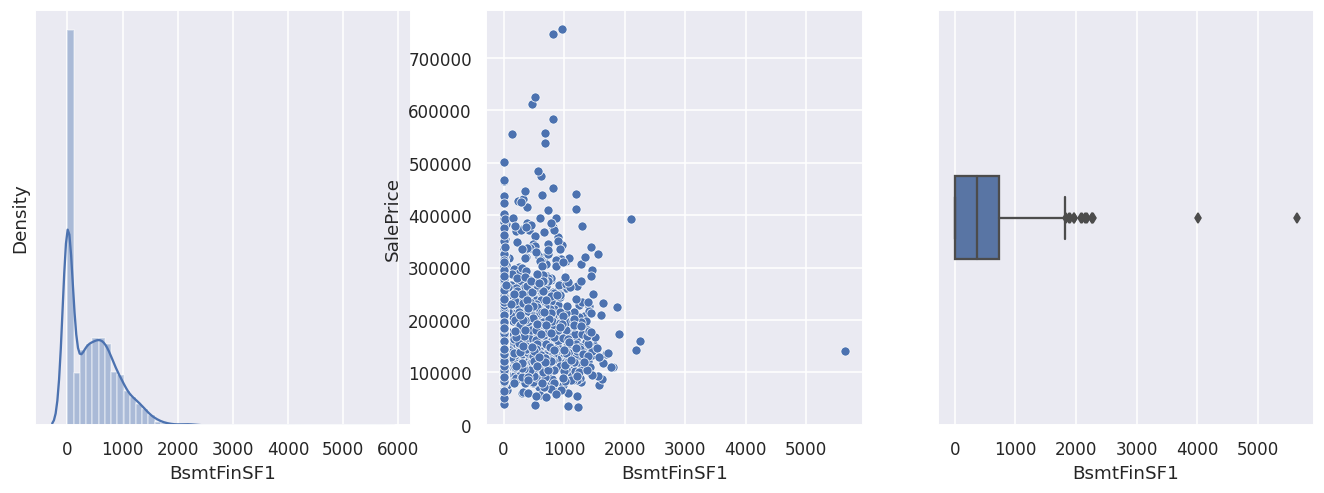

In [1201]:
plot_numeric_features("BsmtFinSF1").show()

## TotalBsmtSF

Skewness Coefficient of LotFrontage is 1.16
Kurotisis Co-efficient: 3.133


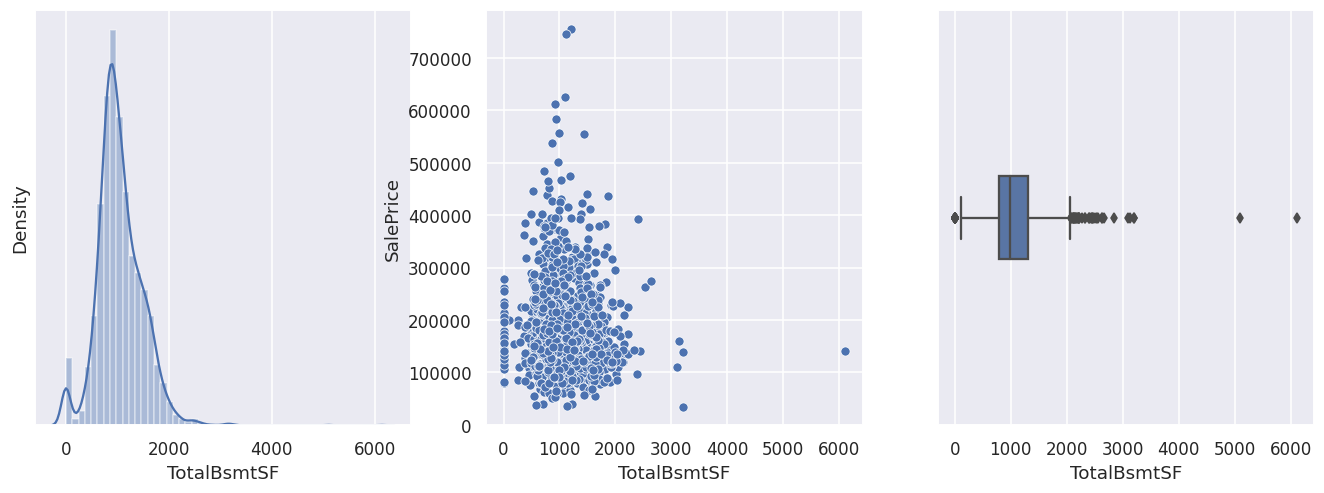

In [1202]:
plot_numeric_features("TotalBsmtSF").show()

### 1sfFlrSF

Skewness Coefficient of LotFrontage is 1.47
Kurotisis Co-efficient: 3.133


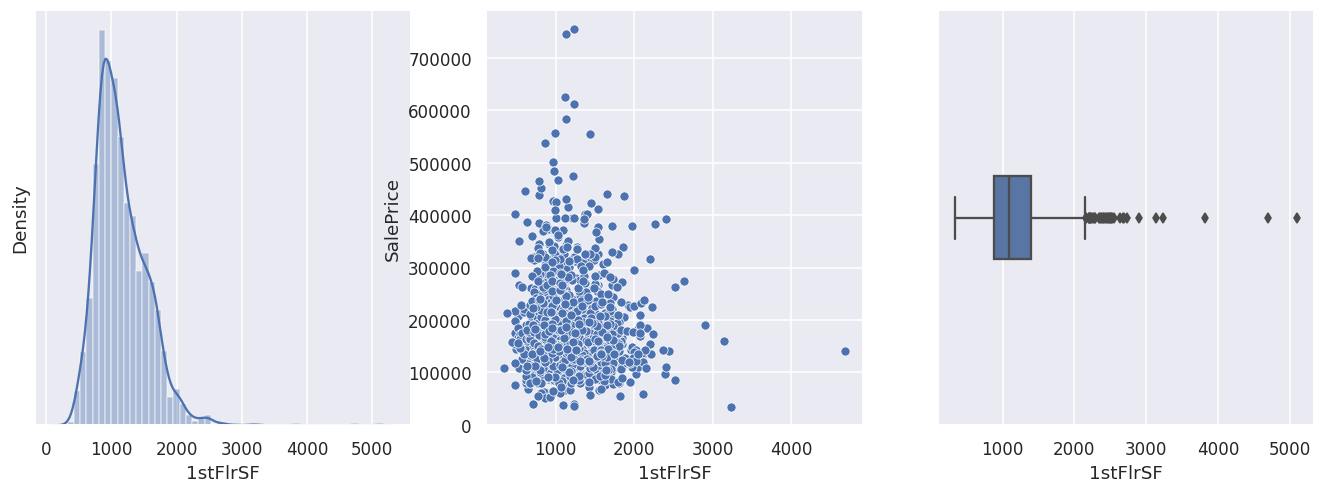

In [1203]:
plot_numeric_features("1stFlrSF").show()

### GrLivArea

Skewness Coefficient of LotFrontage is 1.27
Kurotisis Co-efficient: 3.133


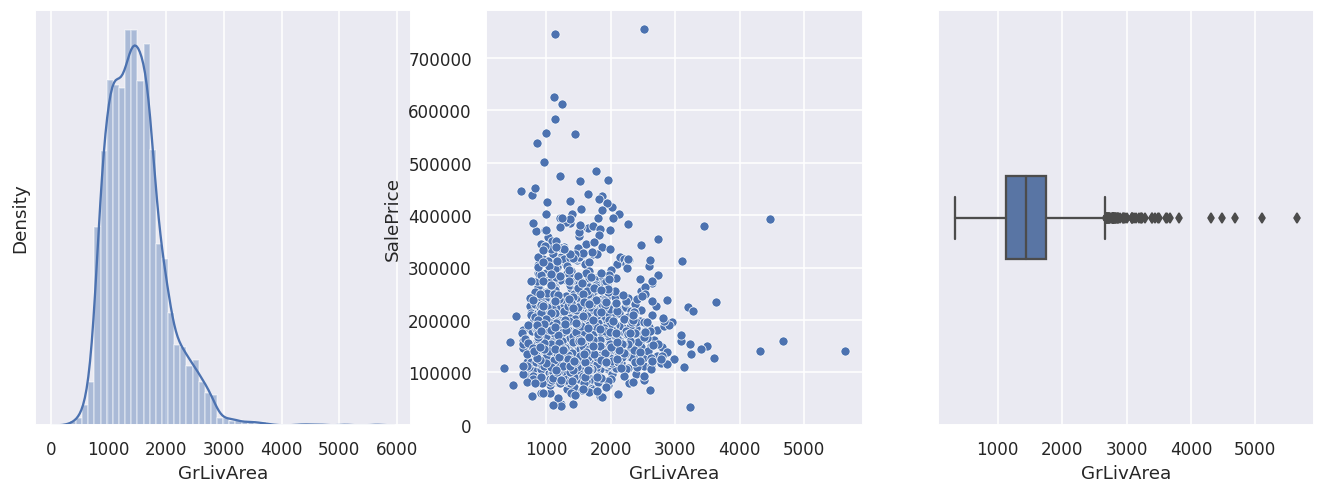

In [1204]:
plot_numeric_features("GrLivArea").show()

In [1205]:
drop_index = concat_data['LotFrontage'][concat_data['LotFrontage'] > 300].index
drop_index = np.append(drop_index, concat_data['LotArea'][concat_data['LotArea'] > 100000].index)
drop_index = np.append(drop_index, concat_data['BsmtFinSF1'][concat_data['BsmtFinSF1'] > 5000].index)
drop_index = np.append(drop_index, concat_data['TotalBsmtSF'][concat_data['TotalBsmtSF'] > 6000].index)
drop_index = np.append(drop_index, concat_data['1stFlrSF'][concat_data['1stFlrSF'] > 4000].index)
drop_index = np.append(drop_index, concat_data['GrLivArea'][(concat_data['GrLivArea'] > 4000) & (concat_data['SalePrice'] < 268_337)].index)

In [1206]:
## Making sure we only remove data from the train set
drop_index = drop_index[drop_index < ntrain]

concat_data = concat_data.drop(drop_index).reset_index(drop=True)

## Length of indexes dropped
dropped_count = len(drop_index)

## Modify our ntrain variable
ntrain -= dropped_count

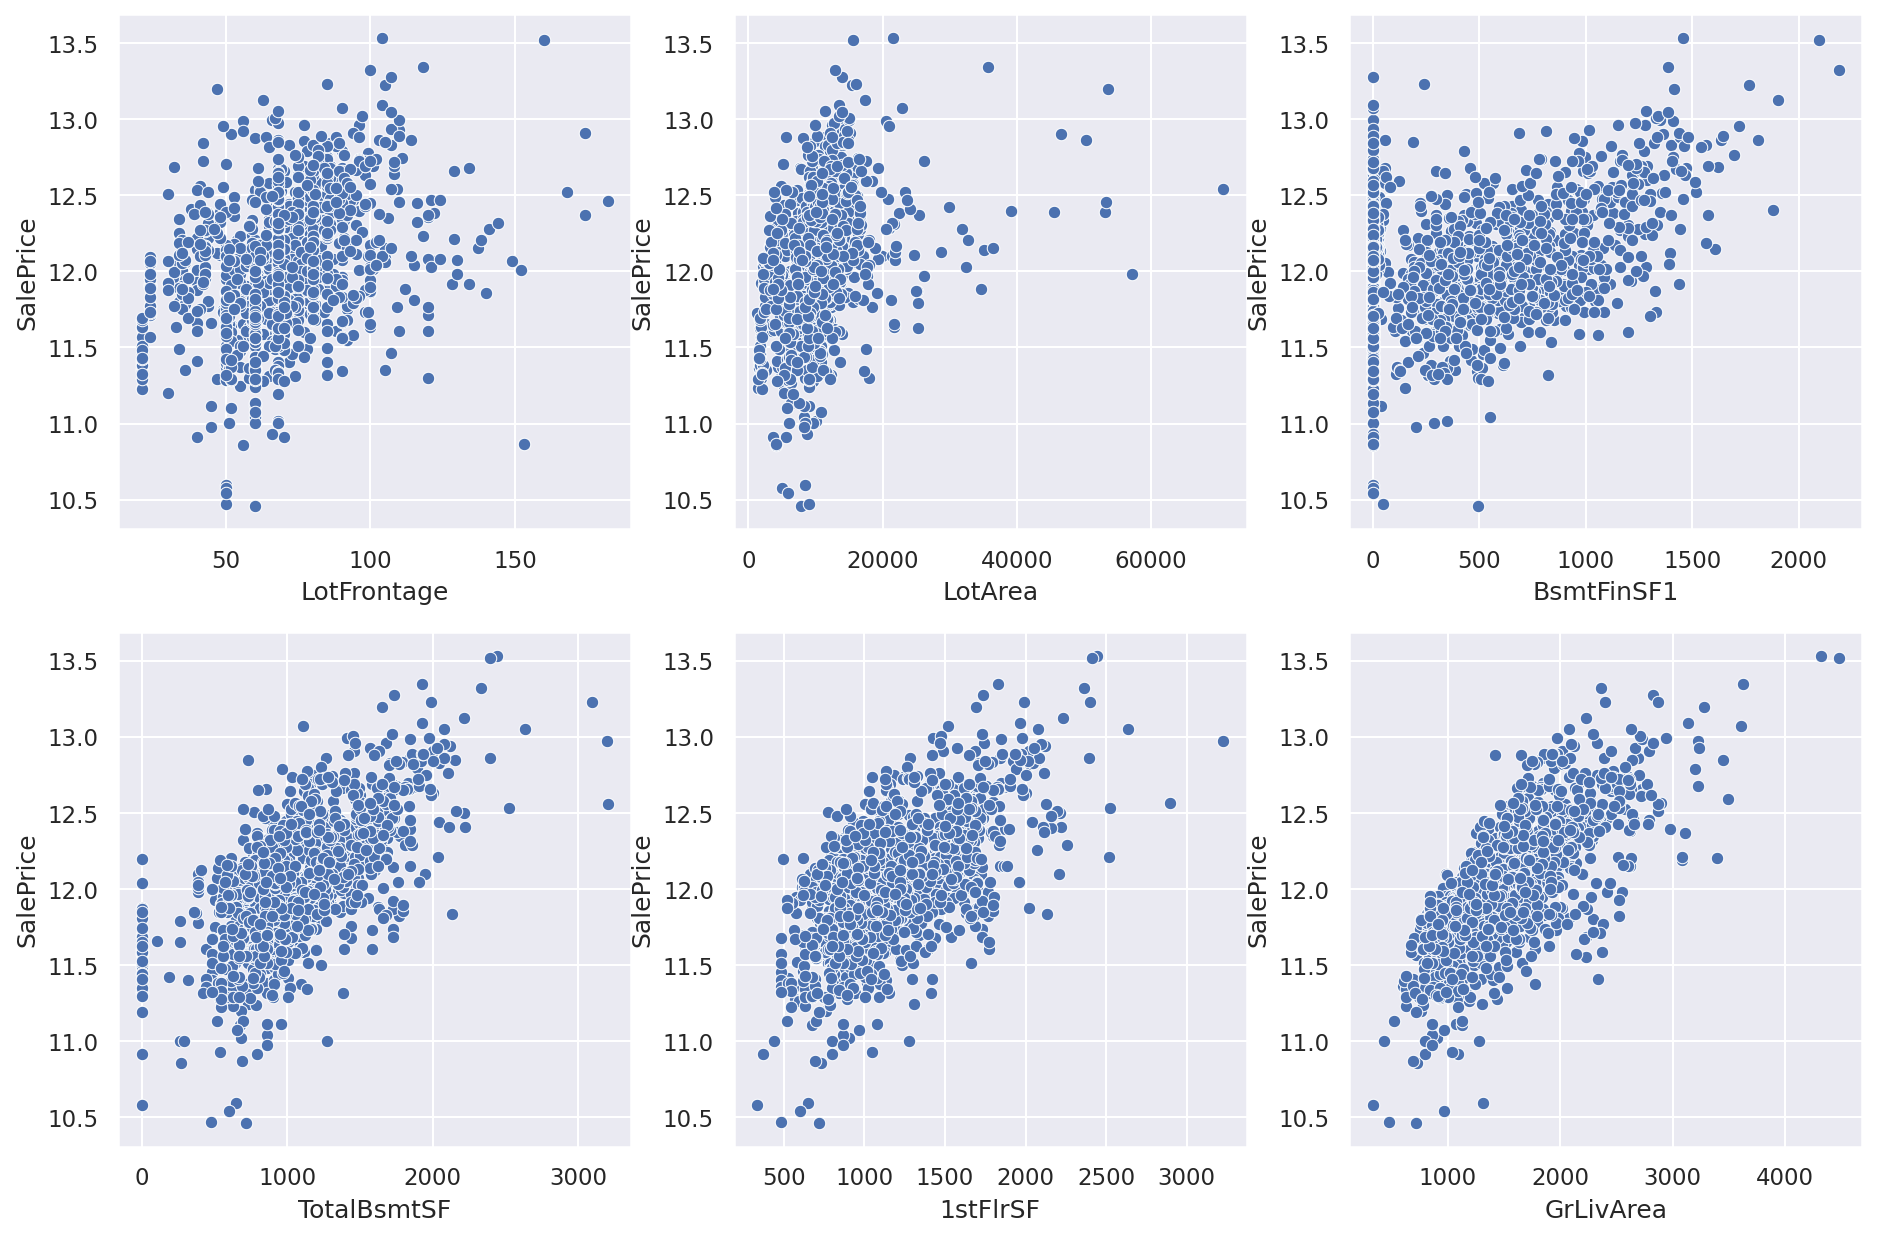

In [1207]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10), dpi=150)

def create_scatter_plot(feature, axis):
    sns.scatterplot(concat_data[feature],np.log1p(concat_data["SalePrice"]), ax=axis)
    
create_scatter_plot('LotFrontage', ax1)
create_scatter_plot('LotArea', ax2)
create_scatter_plot('BsmtFinSF1', ax3)
create_scatter_plot('TotalBsmtSF', ax4)
create_scatter_plot('1stFlrSF', ax5)
create_scatter_plot('GrLivArea', ax6)

plt.show()

## Variables by type

### Quantitative value

In [1208]:
# discrete_variables = ["BsmtFullBath","BsmtHalfBath","FullBath","HalfBath",
#                       "Kitchen", "TotRmsAbvGrd", "Fireplaces", "GarageCars"]

# continuous_variables = ["LotFrontage","LotArea", "Age", "AgeRemod",
#                         '1stFlrSF', '2ndFlrSF', 'GrLivArea', "MasVnrArea",
#                         "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF",
#                         "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea",
#                         "TotalSF", "GarageArea", "WoodDeckSF", "OpenPorchSF", 
#                         "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea",
#                         "MiscVal", "SalePrice"]

# ordinal_variables = ["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure",
#                      "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual",
#                      "GarageCond", "PoolQC", "Fence"]

# nominal_variable = ["MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour",
#                     "Utilities", "LotConfig", "LandSlope", "Neighborhood", "Condition1", "Condition2",
#                     "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd",
#                     "MasVnrType", "Foundation", "Heating", "CentralAir", "Electrical", "Functional",
#                    "GarageType", "GarageFinish", "PavedDrive", "MiscFeature", "SaleType", "SaleCondition"]

In [1209]:
numeric_features = concat_data.skew().index
skewed_features = concat_data[numeric_features].skew()[np.abs(concat_data[numeric_features].skew()) > 0.5].index
concat_data[numeric_features] = np.log1p(concat_data[numeric_features])  

In [1210]:
categorical_variables = concat_data.select_dtypes("object").columns
## One-Hot Encoding all the categorical variables but dropping one of the features among them.
drop_categ = []
for categorical_feature in categorical_variables:    
    drop_categ += [ i+'_'+str(concat_data[i].unique()[-1]) ]

## Create dummy variables (One-Hot Encoding)
concat_data = pd.get_dummies(concat_data, columns=categorical_variables) 

## Drop the last column generated from each categorical feature
concat_data.drop(drop_categ, axis=1, inplace=True)

# Write numeric features
numeric_features = numeric_features.drop('SalePrice')
numeric_features = pd.DataFrame(numeric_features, columns=["column"])

# Splitting Data

In [1211]:
X_train =  concat_data[:-ntest].drop(['SalePrice'], axis=1)
y_train =  concat_data[:-ntest]['SalePrice']
X_test  =  concat_data[-ntest:].drop(['SalePrice'], axis=1)

## Writing Data

In [1212]:
X_train.to_csv("../data/processed/training_features.csv")
y_train.to_csv("../data/processed/training_target.csv")
X_test.to_csv("../data/processed/test_set.csv")
numeric_features.to_csv("../data/processed/numeric_features_list.csv")